<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:3**

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

In [132]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [133]:
flotation = pd.read_csv('Flotation_Plant_Clean.csv')

##**5. Exploratory Data Analysis**

###**5.1. Dataset summary statistics**

In [134]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


### **5.2. Variable Reduction**

- Flotation froth level measurements and date do not effect the output silica percentage.
- Then we will drop level columns
- Air flow of seven columns measurements can be merged by taking mean, only one value.  
- Other variables affect the percentage of iron and silica.

In [135]:
# Drop the level columns
level_columns = ['level_col1', 'level_col2', 'level_col3', 'level_col4',
                 'level_col5', 'level_col6', 'level_col7']
flotation.drop(level_columns, axis=1, inplace=True)

# Drop the 'date' column
flotation.drop('date', axis=1, inplace=True)

# Calculate the mean of the airflow columns
airflow_columns = ['airflow_col1', 'airflow_col2', 'airflow_col3', 'airflow_col4',
                   'airflow_col5', 'airflow_col6', 'airflow_col7']
flotation['airflow_mean'] = flotation[airflow_columns].mean(axis=1).round(3)  # Round to 3 decimal places

# Drop the individual airflow columns
flotation.drop(airflow_columns, axis=1, inplace=True)

# Reorder the columns
column_order = ['iron_feed', 'silica_feed', 'starch_flow',
                'amina_flow', 'pulp_flow', 'pulp_pH', 
                'pulp_density', 'airflow_mean', 
                'iron_conc', 'silica_conc']
flotation = flotation[column_order]

In [136]:
flotation.head().T

,0,1,2,3,4
iron_feed,55.200,55.200,55.200,55.200,55.200
silica_feed,16.980,16.980,16.980,16.980,16.980
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.070,10.070,10.070,10.070,10.070
pulp_density,1.740,1.740,1.740,1.740,1.740
airflow_mean,265.090,264.534,264.120,265.360,264.663
iron_conc,66.910,66.910,66.910,66.910,66.910
silica_conc,1.310,1.310,1.310,1.310,1.310


In [137]:
missing_values = flotation.isnull().sum()
print(missing_values)

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_mean    0
iron_conc       0
silica_conc     0
dtype: int64


In [138]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

iron_feed       113
silica_feed     113
starch_flow     113
amina_flow      113
pulp_flow       113
pulp_pH         113
pulp_density    113
airflow_mean    113
iron_conc       113
silica_conc     113
dtype: int64

In [139]:
flotation.drop_duplicates(inplace=True)

In [140]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_mean    0
iron_conc       0
silica_conc     0
dtype: int64

In [141]:
round(flotation.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
iron_feed,726340.0,56.30,5.16,42.74,52.67,56.08,59.72,65.78
silica_feed,726340.0,14.65,6.81,1.31,8.94,13.85,19.60,33.40
starch_flow,726340.0,338.29,146.90,0.20,235.16,326.52,395.93,999.98
amina_flow,726340.0,488.13,91.30,241.67,431.78,504.31,553.35,739.54
pulp_flow,726340.0,397.57,9.71,376.25,394.24,399.23,402.97,418.64
pulp_pH,726340.0,9.77,0.39,8.75,9.53,9.80,10.04,10.81
pulp_density,726340.0,1.68,0.07,1.52,1.65,1.70,1.73,1.85
airflow_mean,726340.0,288.64,18.72,218.46,277.78,298.66,300.46,330.50
iron_conc,726340.0,65.05,1.12,62.05,64.37,65.21,65.86,68.01
silica_conc,726340.0,2.33,1.13,0.60,1.44,2.00,3.01,5.53


In [142]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726340 entries, 0 to 726452
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   iron_feed     726340 non-null  float64
 1   silica_feed   726340 non-null  float64
 2   starch_flow   726340 non-null  float64
 3   amina_flow    726340 non-null  float64
 4   pulp_flow     726340 non-null  float64
 5   pulp_pH       726340 non-null  float64
 6   pulp_density  726340 non-null  float64
 7   airflow_mean  726340 non-null  float64
 8   iron_conc     726340 non-null  float64
 9   silica_conc   726340 non-null  float64
dtypes: float64(10)
memory usage: 61.0 MB


###**5.2. Corellation between the variables**

In [143]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_mean,iron_conc,silica_conc
iron_feed,1.000000,-0.971889,-0.008469,-0.087716,0.161240,0.007522,-0.125120,-0.078970,0.055908,-0.077142
silica_feed,-0.971889,1.000000,0.018508,0.078221,-0.151096,0.008045,0.103829,0.105727,-0.044665,0.072751
starch_flow,-0.008469,0.018508,1.000000,0.026758,0.027647,0.142268,-0.062792,0.090031,0.022243,-0.027689
amina_flow,-0.087716,0.078221,0.026758,1.000000,0.212825,0.124606,0.655333,0.121051,-0.110413,0.156844
pulp_flow,0.161240,-0.151096,0.027647,0.212825,1.000000,0.118035,0.013239,-0.155265,0.082714,0.008698
pulp_pH,0.007522,0.008045,0.142268,0.124606,0.118035,1.000000,0.116813,0.176083,0.192411,-0.147287
pulp_density,-0.125120,0.103829,-0.062792,0.655333,0.013239,0.116813,1.000000,-0.019256,0.015669,0.046373
airflow_mean,-0.078970,0.105727,0.090031,0.121051,-0.155265,0.176083,-0.019256,1.000000,0.049406,-0.163775
iron_conc,0.055908,-0.044665,0.022243,-0.110413,0.082714,0.192411,0.015669,0.049406,1.000000,-0.800712
silica_conc,-0.077142,0.072751,-0.027689,0.156844,0.008698,-0.147287,0.046373,-0.163775,-0.800712,1.000000


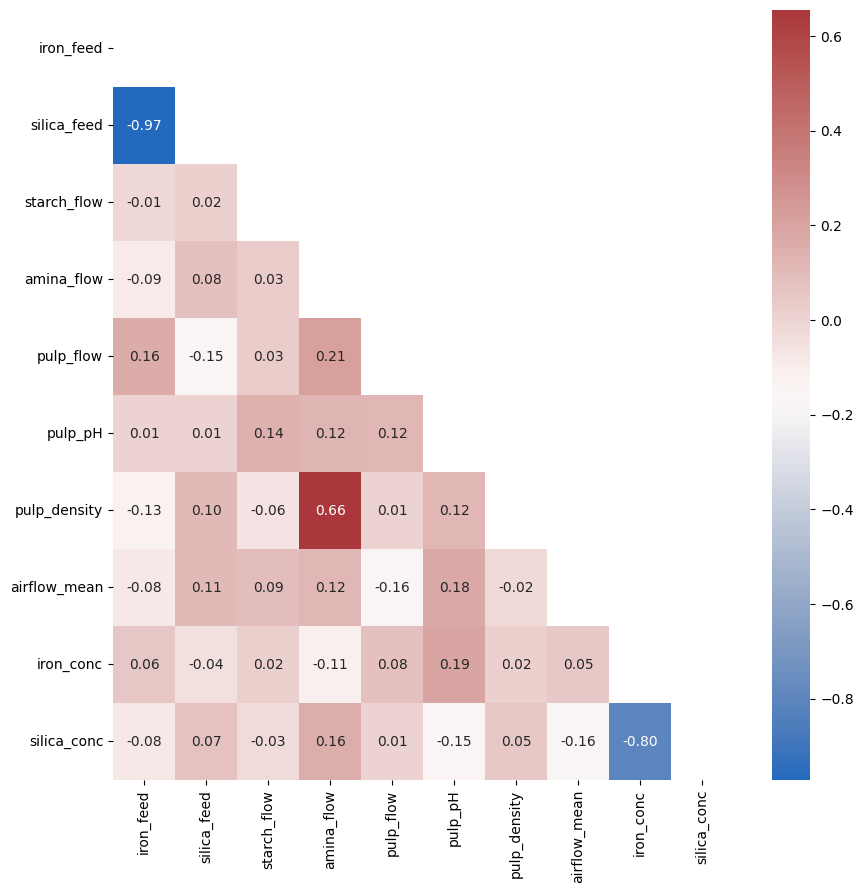

In [144]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()

In [145]:
correlation = flotation.corr().abs()
mask = correlation.mask(np.triu(np.ones(correlation.shape, dtype=bool)))
sorted_correlation = mask.unstack().sort_values(ascending=False)
sorted_correlation = sorted_correlation[(sorted_correlation > 0.65) & (sorted_correlation < 1.0)].reset_index()

# Rename the columns
sorted_correlation.columns = ['variable_1', 'variable_2', 'correlation_degree']

# Reorder the columns
sorted_correlation = sorted_correlation[['variable_1', 'variable_2', 'correlation_degree']]

sorted_correlation

,variable_1,variable_2,correlation_degree
0,iron_feed,silica_feed,0.971889
1,iron_conc,silica_conc,0.800712
2,amina_flow,pulp_density,0.655333


###**5.3. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [146]:

flotation.columns

Index(['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_mean', 'iron_conc', 'silica_conc'],
      dtype='object')

In [147]:
from sklearn.preprocessing import MinMaxScaler

#Select the columns to normalize
columns_to_normalize = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
                         'pulp_pH', 'pulp_density', 'airflow_mean', 'iron_conc', 'silica_conc']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


###**5.4. Check & remove outliers**

- Visualize the variables for seeing outliers

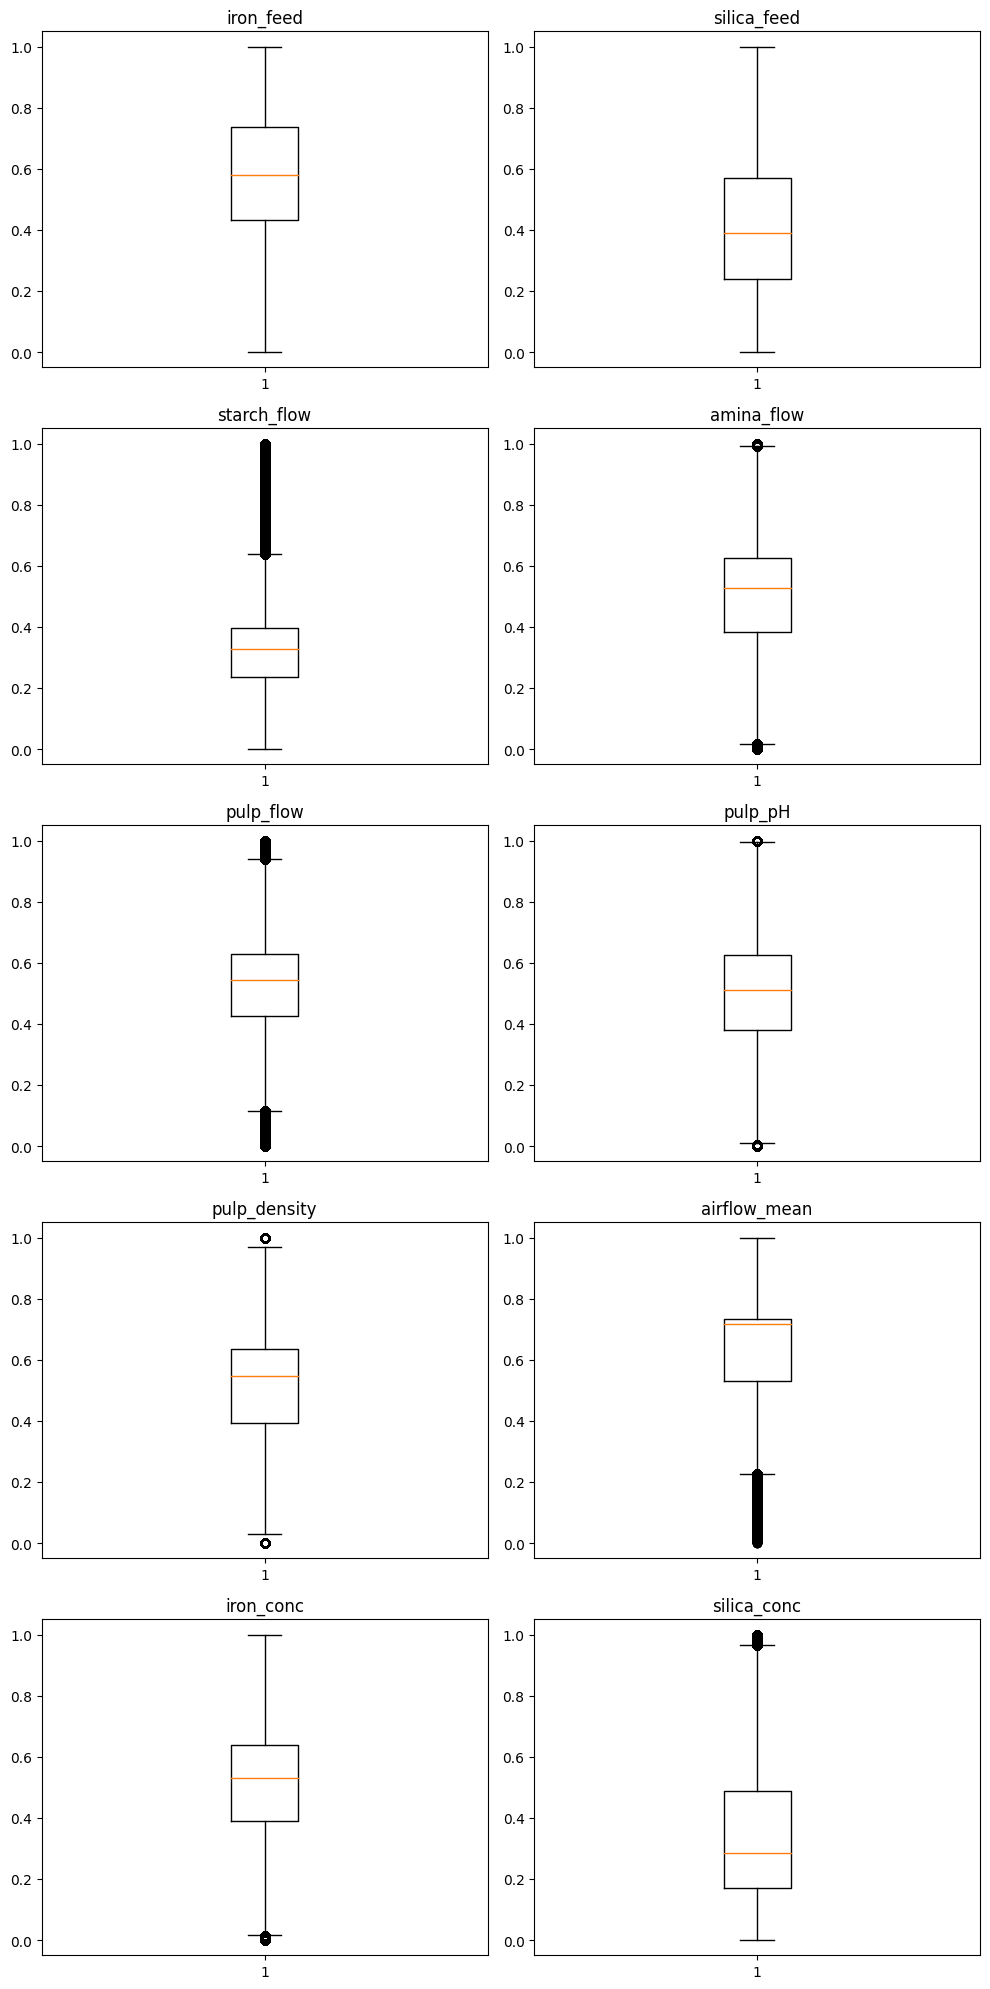

In [148]:
import matplotlib.pyplot as plt

# Assuming 'flotation' is the name of your dataset DataFrame
variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
             'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_mean',
             'iron_conc', 'silica_conc']

num_variables = len(variables)

# Create subplots with appropriate number of rows and columns
num_rows = (num_variables - 1) // 2 + 1
num_cols = min(2, num_variables)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Flatten the axs array if needed
if num_variables == 1:
    axs = [axs]

# Iterate over variables and plot boxplots
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    axs[row][col].boxplot(flotation[variable])
    axs[row][col].set_title(variable)

plt.tight_layout()
plt.show()


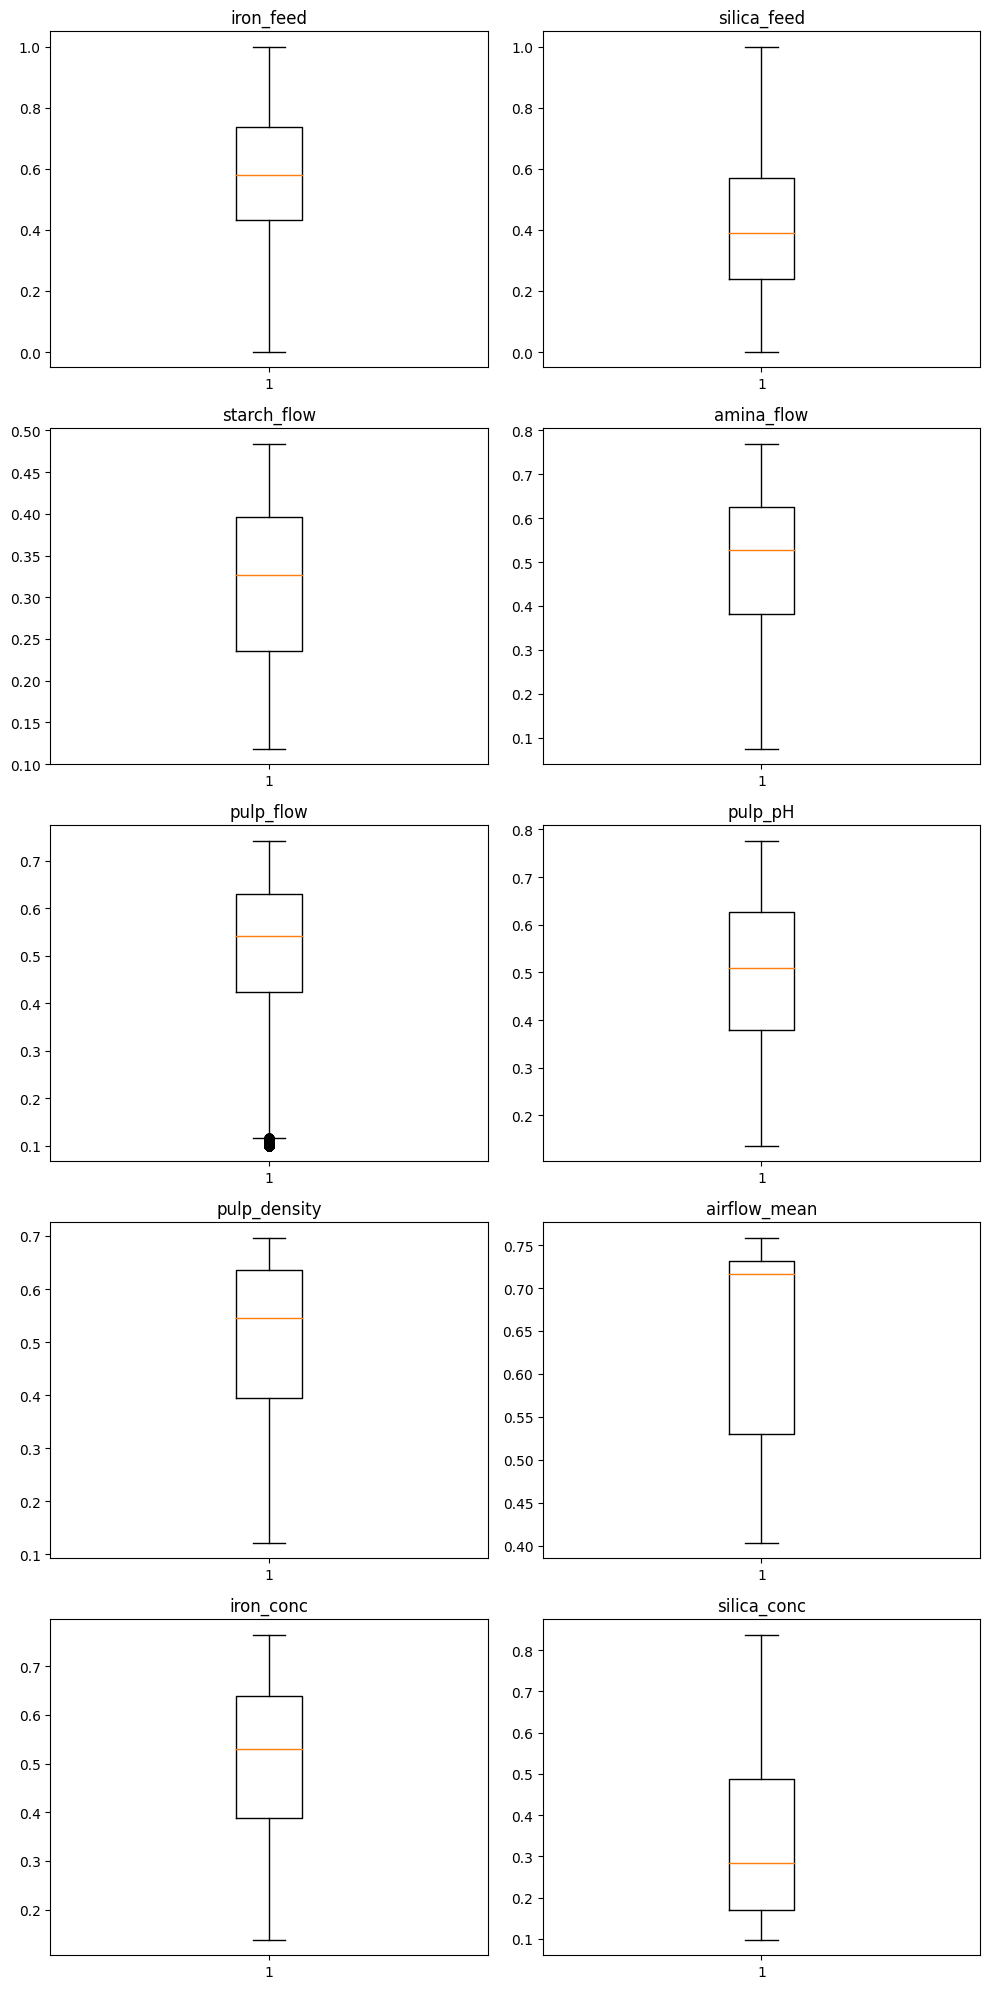

In [149]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Assuming 'flotation' is the name of your dataset DataFrame
variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
             'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_mean',
             'iron_conc', 'silica_conc']

# Define the limit values for each variable
limit_values = {
    'iron_feed': (0.0, 0.0),
    'silica_feed': (0.0, 0.0),
    'starch_flow': (0.02, 0.1),
    'amina_flow': (0.03, 0.03),
    'pulp_flow': (0.1, 0.1),
    'pulp_pH': (0.05, 0.05),
    'pulp_density': (0.1, 0.1),
    'airflow_mean': (0.1, 0.1),
    'iron_conc': (0.05, 0.05),
    'silica_conc': (0.05, 0.05)
}

num_variables = len(variables)

# Create subplots with appropriate number of rows and columns
num_rows = (num_variables - 1) // 2 + 1
num_cols = min(2, num_variables)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Flatten the axs array if needed
if num_variables == 1:
    axs = [axs]

# Iterate over variables and plot boxplots
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    
    # Apply Winsorization with the specific limit values for each variable
    winsorized_data = winsorize(flotation[variable], limits=limit_values[variable])
    
    axs[row][col].boxplot(winsorized_data)
    axs[row][col].set_title(variable)

plt.tight_layout()
plt.show()

###**5.6. Check the skewness, mean and median of independent variables**

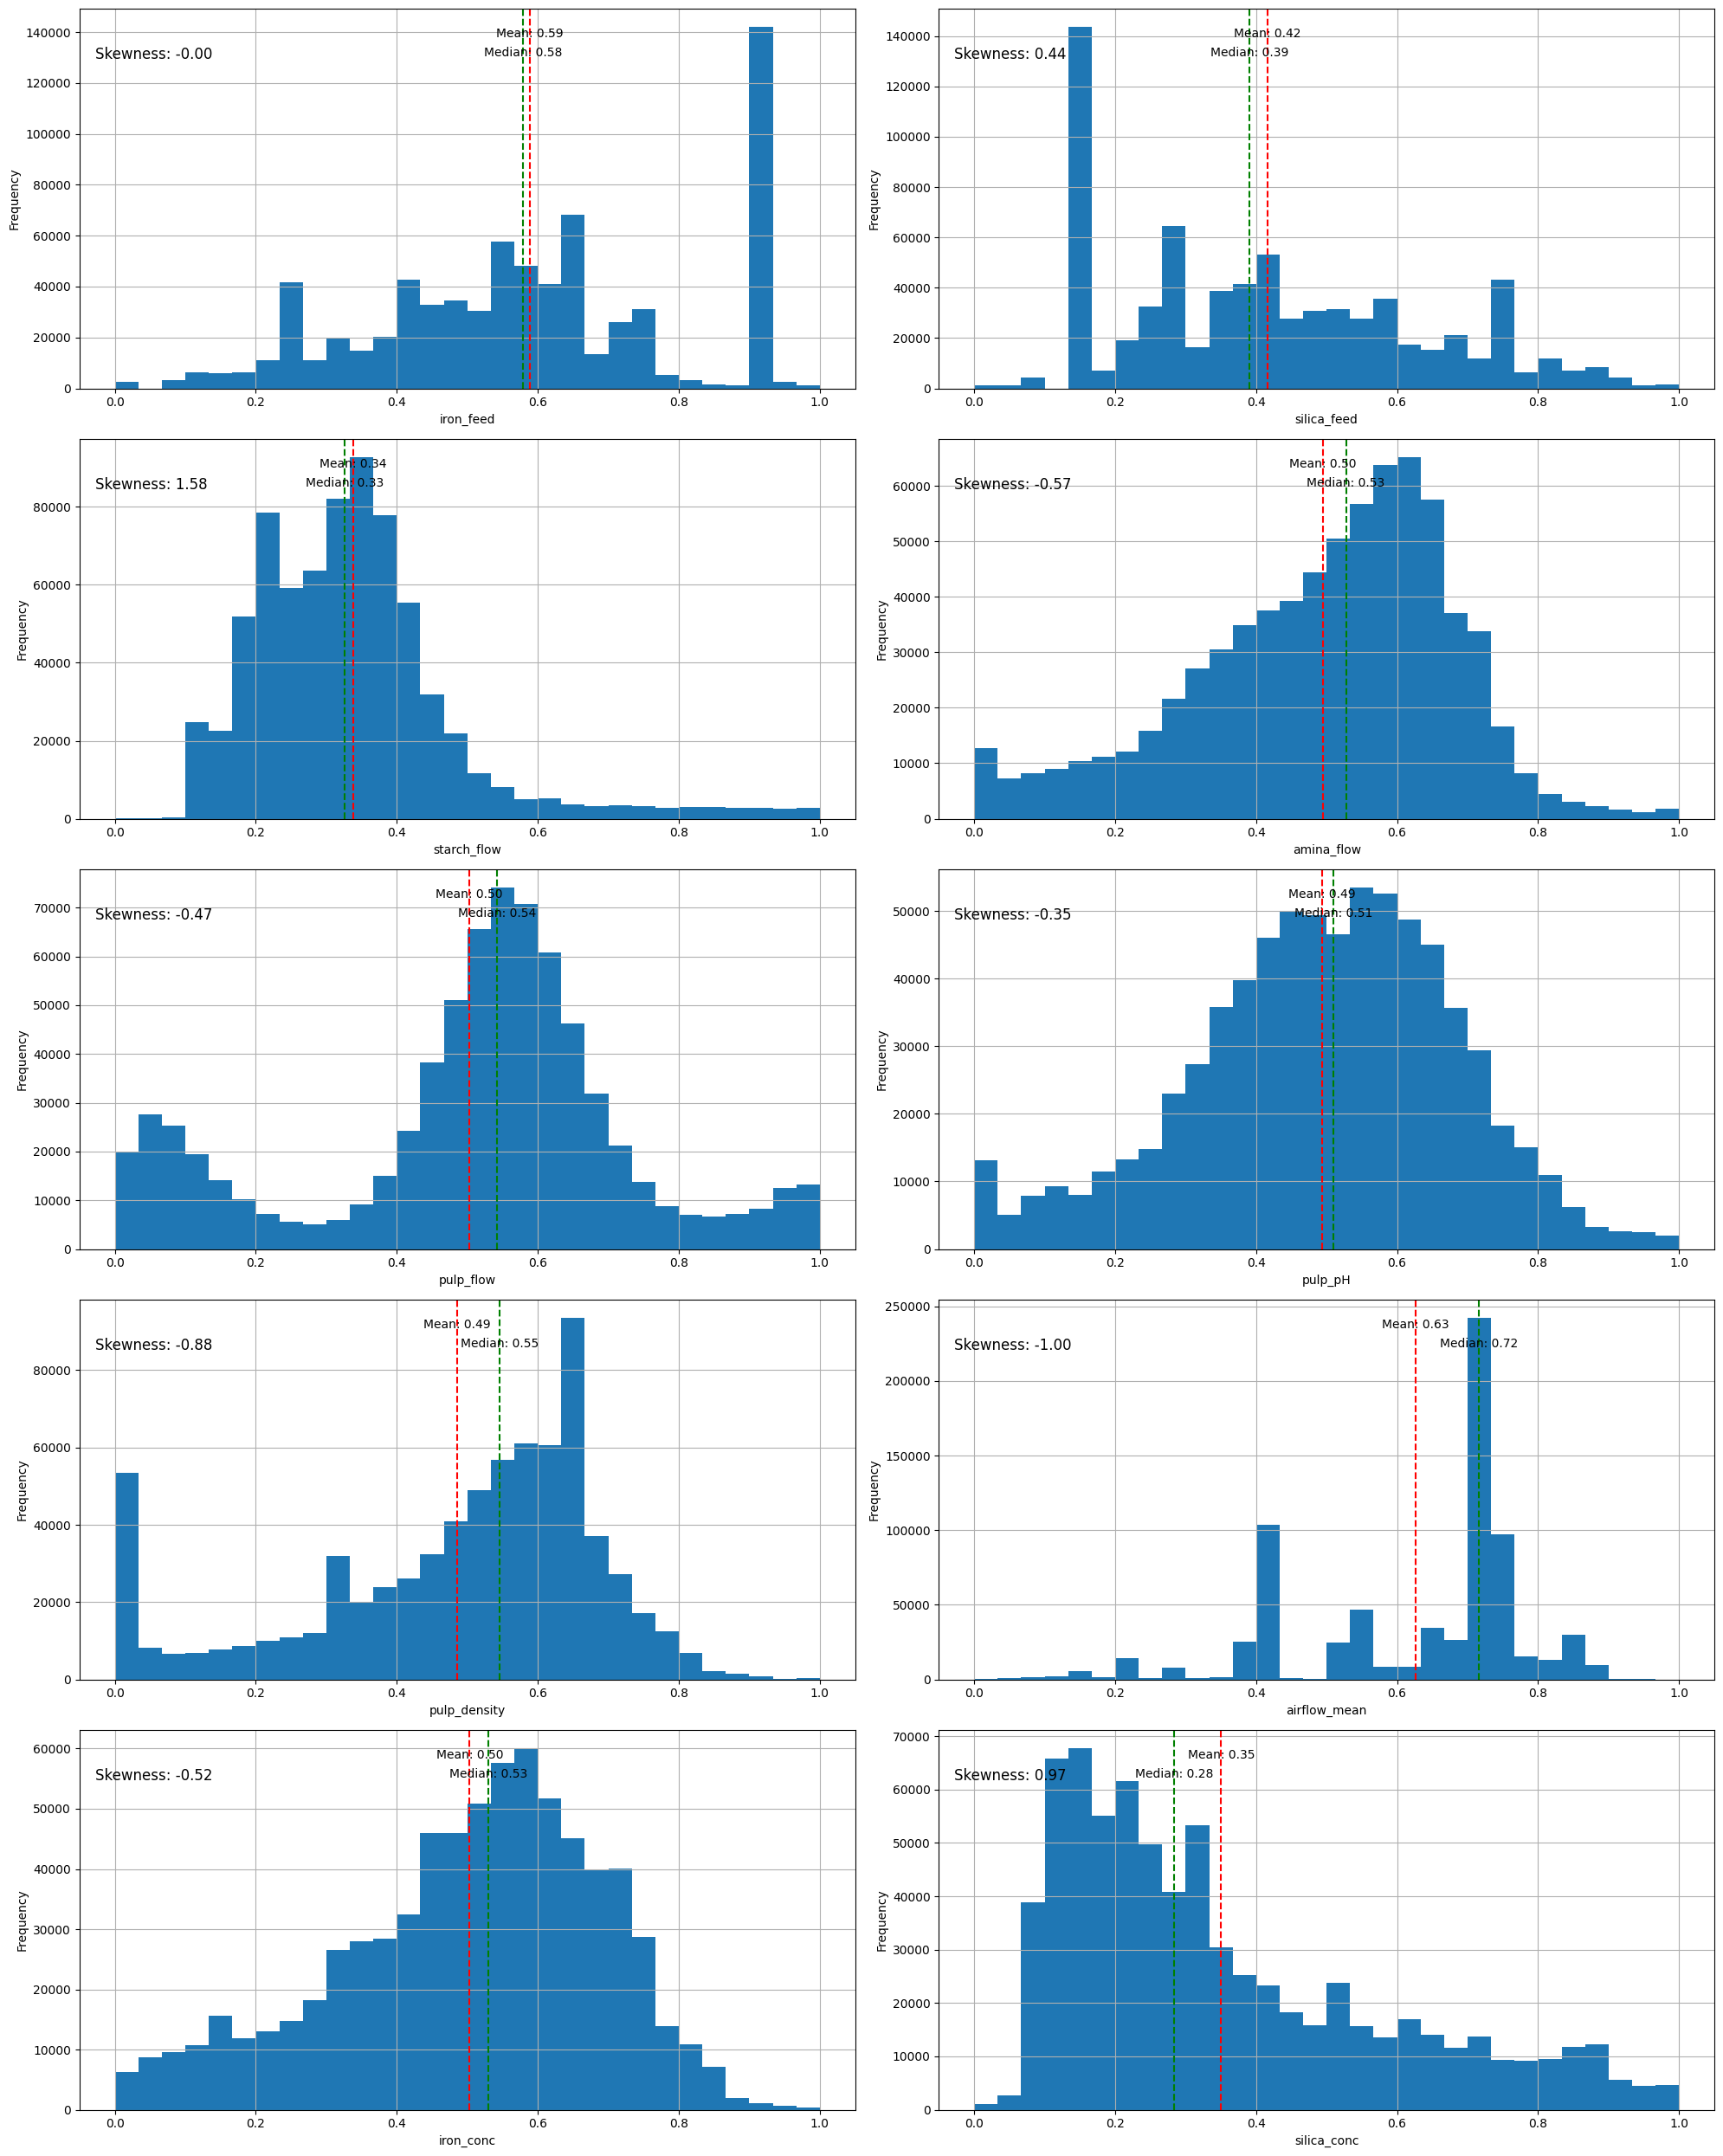

In [150]:
from scipy.stats import skew

variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
             'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_mean',
             'iron_conc', 'silica_conc']

num_vars = len(variables)
num_rows = (num_vars + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

for i, variable in enumerate(variables):
    # Select a specific column for skewness calculation
    data = flotation[variable].to_numpy()
    # Calculate the skewness degree
    skewness = skew(data)
    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plotting the variable in the corresponding subplot
    axes[row, col].hist(data, bins=30)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].axvline(np.mean(data), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data), color='g', linestyle='--')
    # Display the skewness degree in the plot frame
    axes[row, col].text(0.02, 0.9, f"Skewness: {skewness:.2f}",
                        transform=axes[row, col].transAxes, 
                        fontsize=12, verticalalignment='top')
    # Display the mean and median value
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data), ylim[1] - 0.05 * y_range,
                        f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data), ylim[1] - 0.1 * y_range,
                        f"Median: {np.median(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_vars % 2 != 0:
    axes[num_rows - 1, 1].axis('off')

plt.tight_layout()
plt.show()

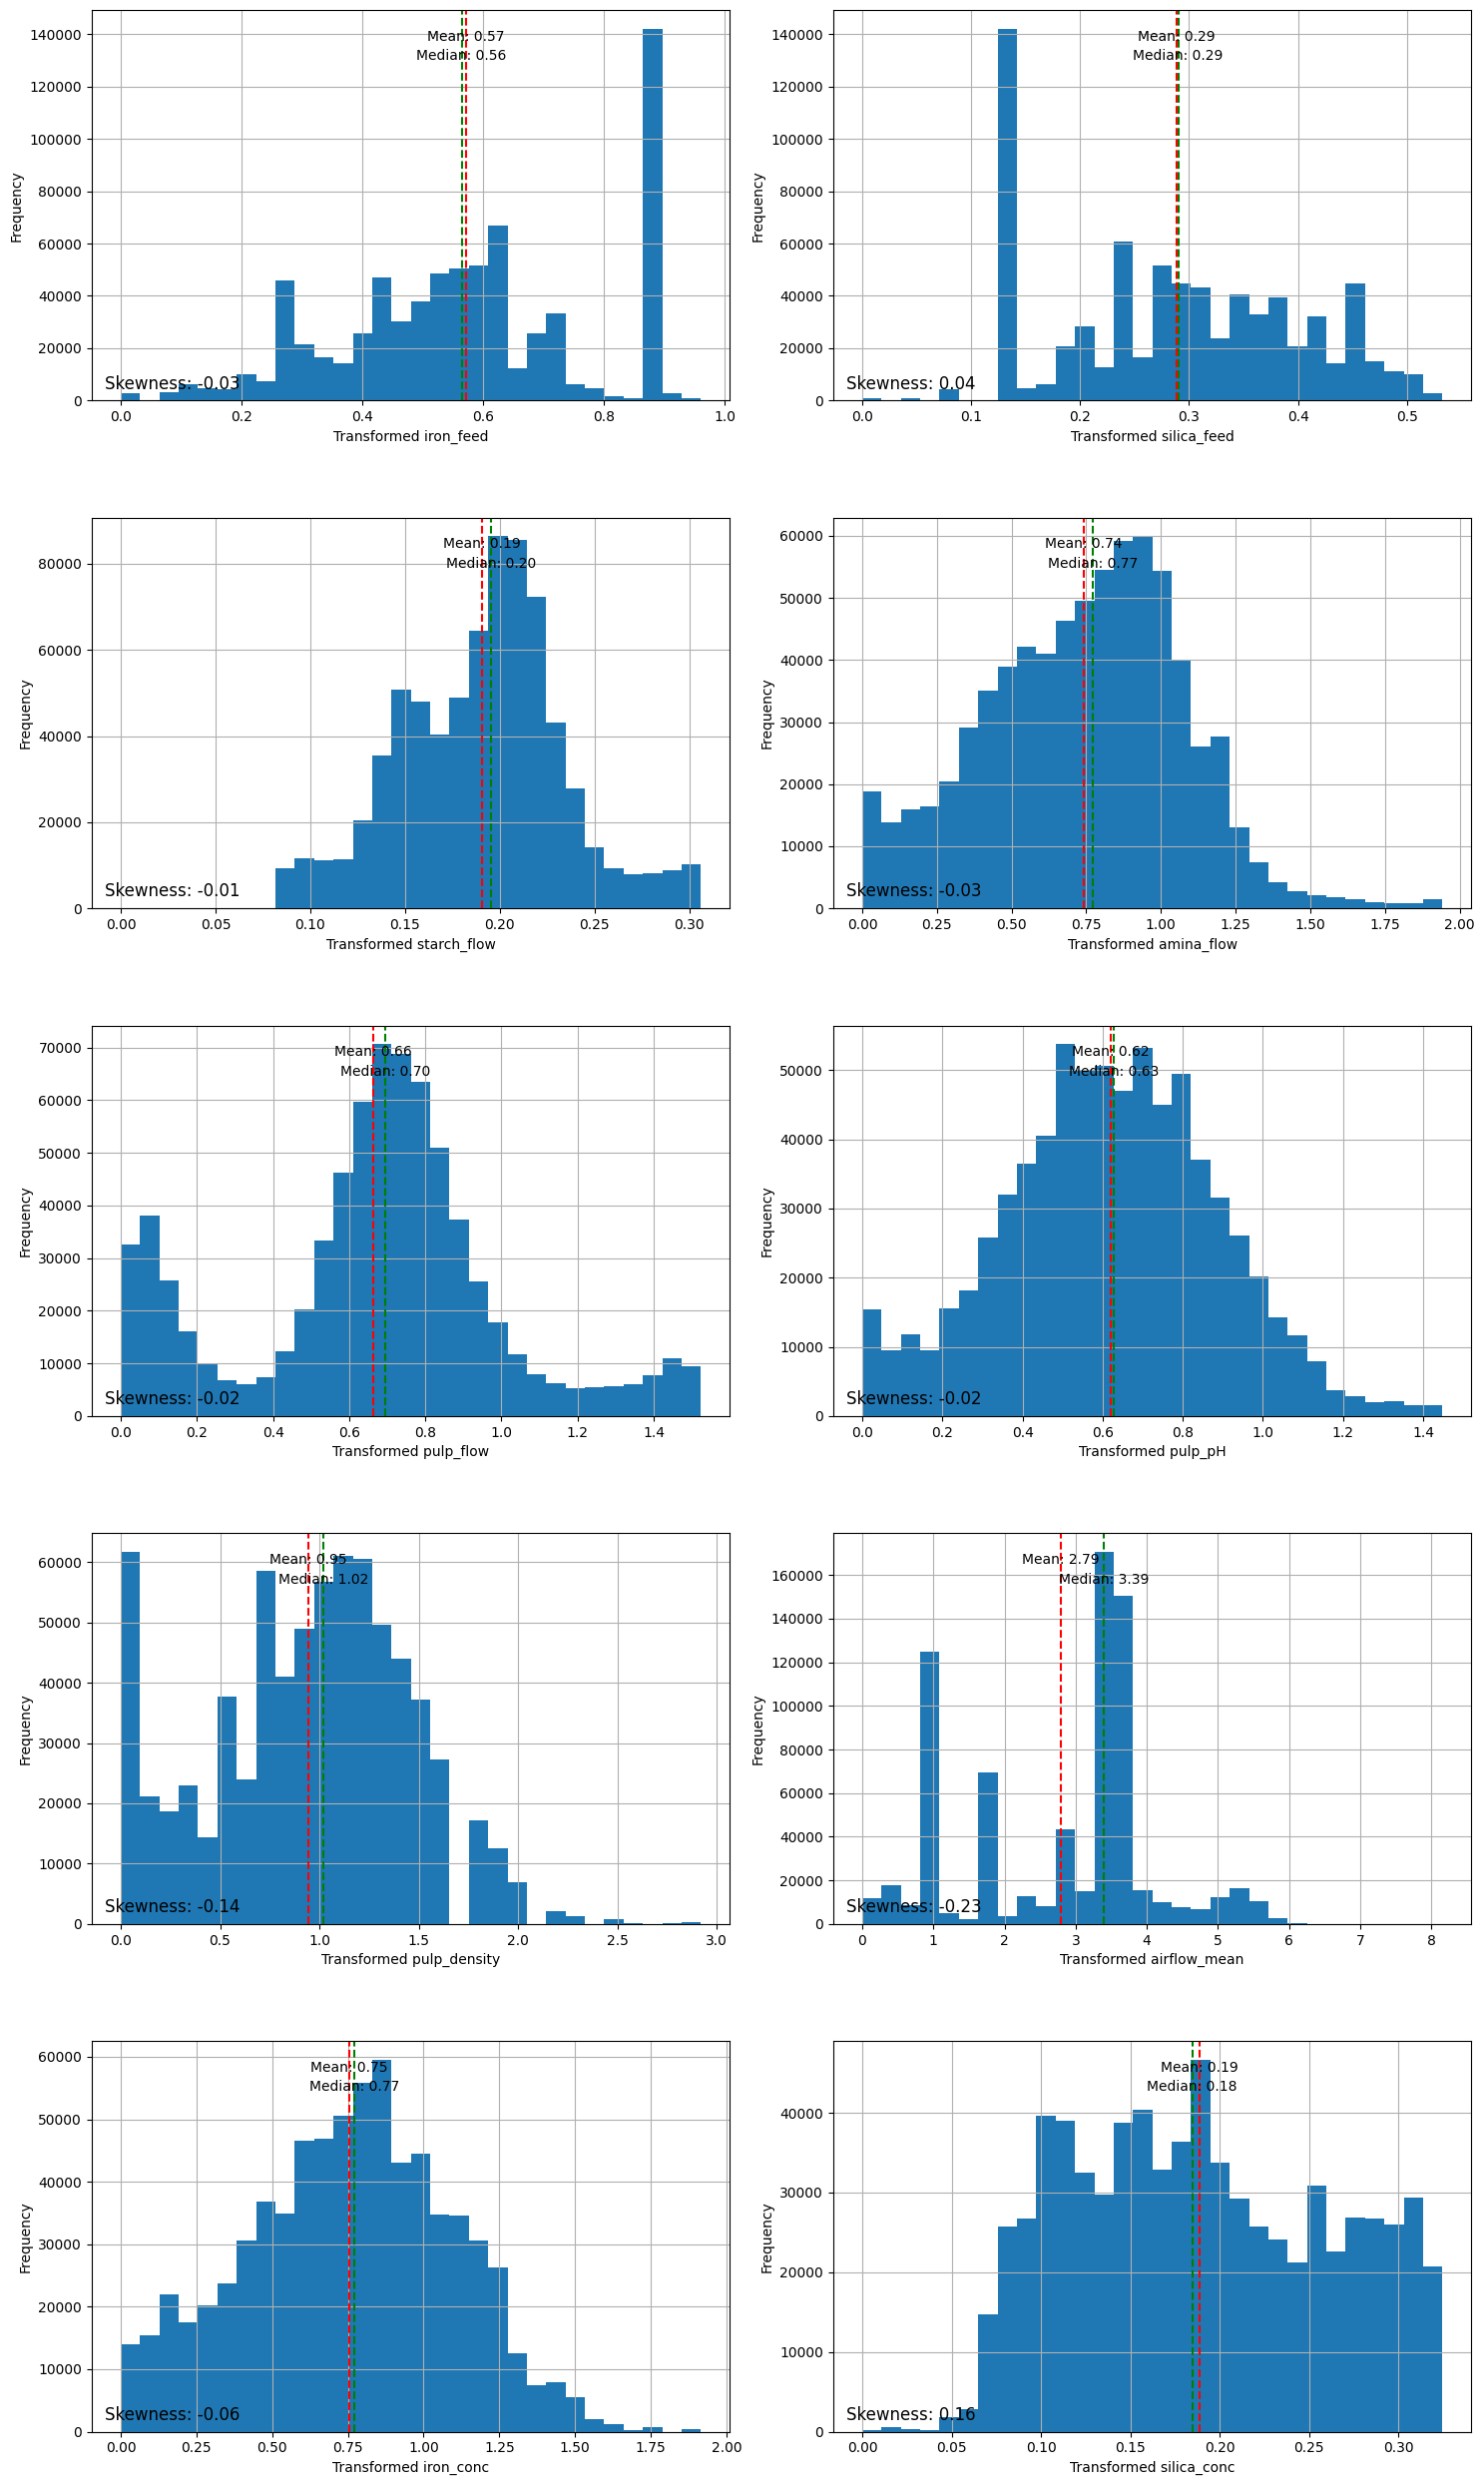

In [151]:
from scipy.stats import boxcox
from scipy.stats import skew

variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
             'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_mean',
             'iron_conc', 'silica_conc']

num_variables = len(variables)
num_rows = num_variables // 2 + num_variables % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2
    
    # Select the specific column for transformation
    data = flotation[variable].to_numpy()
    
    # Shift the data by a constant value
    shifted_data = data - np.min(data) + 1  # Add 1 to ensure all values are positive
    
    # Apply the Box-Cox transformation
    data_transformed, lambda_value = boxcox(shifted_data)
    
    # Update the column in the 'flotation' DataFrame with the transformed values
    flotation[variable] = data_transformed
    
    # Calculate the skewness of the transformed data
    skewness_transformed = skew(data_transformed)
    
    # Plot the histogram of the transformed data
    axes[row, col].hist(data_transformed, bins=30)
    axes[row, col].set_xlabel(f'Transformed {variable}')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].axvline(np.mean(data_transformed), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data_transformed), color='g', linestyle='--')
    
    # Display the skewness degree in the plot
    axes[row, col].text(0.02, 0.02, f"Skewness: {skewness_transformed:.2f}", 
                        transform=axes[row, col].transAxes,
                        fontsize=12, verticalalignment='bottom', 
                        horizontalalignment='left')
    
    # Display the mean and median values
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data_transformed), ylim[1] - 0.05 * y_range,
                 f"Mean: {np.mean(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data_transformed), ylim[1] - 0.1 * y_range,
                 f"Median: {np.median(data_transformed):.2f}", color='black', fontsize=10,
                 verticalalignment='top', horizontalalignment='center')
    axes[row, col].grid(True)

if num_variables % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

###**5.8. Save dropped columns dataset to new file**

In [152]:
flotation.to_csv('/content/drive/My Drive/Flotation/Flotation_Plant_DroppedColumn.csv', index=False)